In [10]:
import numpy as np
import pandas as pd
from visualizer import visualize_cost_matrix, visualize_bipartite_graph
from scipy.optimize import linear_sum_assignment

def load_matrices_from_excel(file_path):
    """
    Loads work_hours, cost, skill, and availability matrices from an Excel file.

    Args:
        file_path (str): Path to the Excel file.

    Returns:
        tuple: A tuple containing the work_hours, cost, skill, and availability matrices.
    """
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)

    # Helper function to load and skip the first column (employee IDs)
    def load_and_skip_first_column(sheet_name):
        df = excel_data.parse(sheet_name)
        return df.iloc[:, 1:].values  # Skip the first column

    # Load each matrix from separate sheets
    work_hours = load_and_skip_first_column("WorkHours")
    cost = load_and_skip_first_column("Cost")
    skill = load_and_skip_first_column("Skill")
    availability = load_and_skip_first_column("Availability")

    return work_hours, cost, skill, availability


def calculate_weighted_matrix(work_hours, cost, skill, availability, weights):
    """
    Calculates a weighted aggregate matrix based on custom scoring logic.

    Args:
        work_hours (np.ndarray): Matrix of work hours required for each worker-task pair.
        cost (np.ndarray): Matrix of costs for each worker-task pair.
        skill (np.ndarray): Matrix of skill levels for each worker-task pair.
        availability (np.ndarray): Matrix of availability (1 for available, 0 for unavailable).
        weights (dict): Weights for each parameter.

    Returns:
        np.ndarray: Weighted aggregate matrix.
    """
    # Initialize the weighted matrix
    weighted_matrix = np.zeros_like(work_hours, dtype=float)

    # Apply custom scoring logic
    for i in range(work_hours.shape[0]):  # Iterate over workers
        for j in range(work_hours.shape[1]):  # Iterate over tasks
            # Penalize unavailability heavily
            if availability[i, j] == 0:
                weighted_matrix[i, j] = float('inf')  # Unavailable workers cannot be assigned
                continue

            # Prioritize skill: Higher skill reduces cost
            skill_score = 1 / (skill[i, j] + 1e-6)  # Avoid division by zero

            # Calculate the weighted score
            score = (
                weights["work_hours"] * work_hours[i, j] +  # Higher work hours increase cost
                weights["cost"] * cost[i, j] +  # Higher cost increases cost
                weights["skill"] * skill_score  # Lower skill increases cost
            )
            weighted_matrix[i, j] = score

    return weighted_matrix

def prioritize_tasks_by_skill(skill_matrix):
    """
    Reorders tasks based on their complexity (higher skill requirements).

    Args:
        skill_matrix (np.ndarray): Matrix of skill levels for each worker-task pair.

    Returns:
        np.ndarray: Reordered skill matrix with tasks sorted by complexity.
    """
    # Calculate the average skill required for each task
    task_complexity = skill_matrix.mean(axis=0)

    # Sort tasks by descending complexity
    sorted_indices = np.argsort(-task_complexity)

    return sorted_indices

def optimize_task_assignment(weighted_matrix):
    """
    Optimally assigns tasks to employees using the Hungarian Assignment Method.

    Args:
        weighted_matrix (np.ndarray): Weighted aggregate matrix.

    Returns:
        tuple: Optimal assignments and total cost.
    """
    # Solve the assignment problem using the Hungarian method
    worker_indices, task_indices = linear_sum_assignment(weighted_matrix)
    total_cost = weighted_matrix[worker_indices, task_indices].sum()
    assignments = list(zip(worker_indices, task_indices))
    return assignments, total_cost


Optimal Assignments:
Employee 1 -> Task 2
Employee 2 -> Task 1
Employee 3 -> Task 3
Employee 4 -> Task 11
Employee 5 -> Task 10
Employee 6 -> Task 9
Employee 7 -> Task 8
Employee 8 -> Task 7
Employee 9 -> Task 6
Employee 10 -> Task 5
Employee 11 -> Task 4
Total Cost: 20.688332325144284


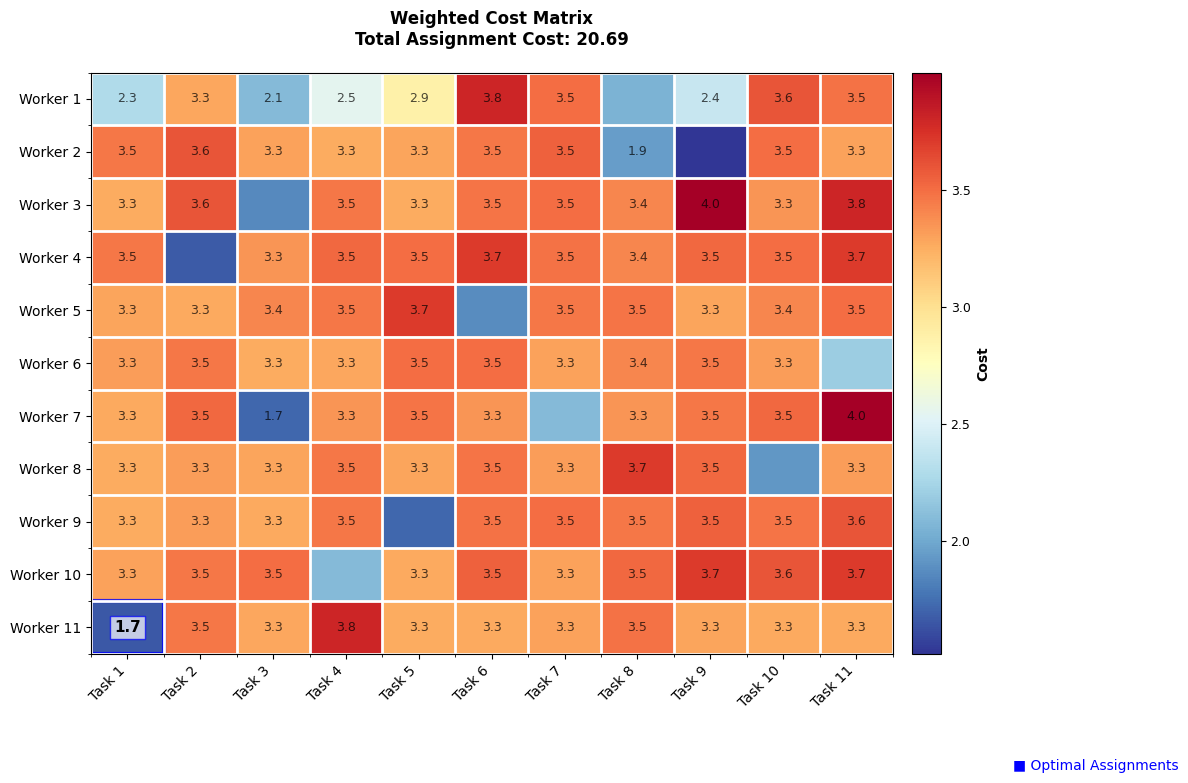

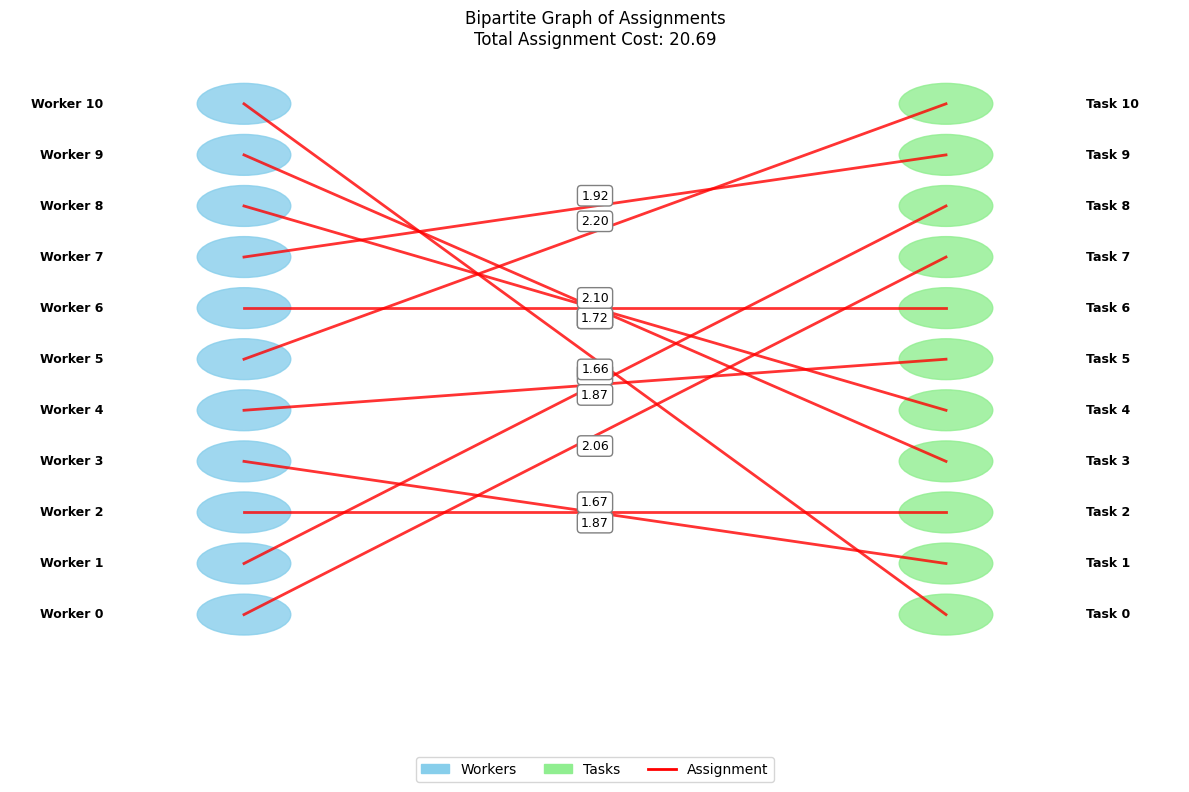

In [11]:
# Path to the Excel file
file_path = "employee_task_assignment1211.xlsx"

# Load matrices from the Excel file
try:
    work_hours, cost, skill, availability = load_matrices_from_excel(file_path)
except Exception as e:
    print(f"Error loading Excel file: {e}")
    exit()

# Define weights for the factors
weights = {"work_hours": 0.2, "cost": 0.2, "skill": 0.6}

# Reorder tasks by complexity (based on skill requirements)
sorted_task_indices = prioritize_tasks_by_skill(skill)
skill = skill[:, sorted_task_indices]
work_hours = work_hours[:, sorted_task_indices]
cost = cost[:, sorted_task_indices]
availability = availability[:, sorted_task_indices]

# Calculate the weighted aggregate matrix
try:
    weighted_matrix = calculate_weighted_matrix(work_hours, cost, skill, availability, weights)
except Exception as e:
    print(f"Error calculating weighted matrix: {e}")
    exit()

# Optimize task assignment
try:
    assignments, total_cost = optimize_task_assignment(weighted_matrix)
except Exception as e:
    print(f"Error during optimization: {e}")
    exit()

# Print the results
print("Optimal Assignments:")
for worker, task in assignments:
    print(f"Employee {worker + 1} -> Task {sorted_task_indices[task] + 1}")
print(f"Total Cost: {total_cost}")

# Visualize the results
visualize_cost_matrix(weighted_matrix, assignments, title="Weighted Cost Matrix")
visualize_bipartite_graph(weighted_matrix, assignments, title="Bipartite Graph of Assignments")


